# SpaceWars

> The location of reporting the Great War in France, Austria and Finland – investigating the places dominating news reporting during the Great War between 1914 and 1918

- https://platform.newseye.eu/

### MultiBERT

In [1]:
!python3 --version

Python 3.6.9


In [2]:
from os.path import join
from os import listdir

listdir(join('multi_cased_L-12_H-768_A-12'))

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt']

In [3]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs')
writer

In [4]:
from transformers import BertTokenizer, BertModel

MODEL = 'bert-base-multilingual-cased'

tokenizer = BertTokenizer.from_pretrained(MODEL)

text = ["I like cats.", "J'aime bien les chats.", 'Ich mag Katzen.']
encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

encoded_input['input_ids']

tensor([[  101,   146, 11850, 41163, 10107,   119,   102,     0,     0,     0],
        [  101,   147,   112, 62691, 12028, 10152, 69338, 10107,   119,   102],
        [  101, 21023, 20722, 76777, 10136,   119,   102,     0,     0,     0]])

In [5]:
import torch

model = BertModel.from_pretrained(MODEL, output_hidden_states=True)
# writer.add_graph(model)
model.eval()

with torch.no_grad():
    output = model(**encoded_input)
output[0].shape

torch.Size([3, 10, 768])

In [6]:
output[2][0].shape

torch.Size([3, 10, 768])

### Visualization

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2)

dims = output[0].shape

vectors = output[0].detach().numpy().reshape(dims[0]*dims[1], 768)

output_2d = pca.fit_transform(vectors)

In [9]:
output[0], vectors

(tensor([[[-6.9672e-02, -8.1205e-02,  6.0374e-01,  ...,  2.7944e-01,
           -5.3708e-01,  3.3668e-01],
          [ 2.0454e-01, -7.6209e-01,  1.1907e+00,  ...,  2.4091e-01,
           -1.1493e+00, -6.3096e-02],
          [ 2.0950e-01, -4.6561e-01,  1.9190e-01,  ...,  5.2618e-01,
           -8.9888e-01,  6.8182e-01],
          ...,
          [-3.9712e-01, -3.7900e-01,  1.0237e+00,  ...,  4.9932e-01,
           -7.5085e-01,  2.2093e-01],
          [-4.9182e-01, -3.9108e-01,  9.9678e-01,  ...,  2.9080e-01,
           -5.3241e-01,  2.6502e-01],
          [-2.5283e-01, -3.9029e-01,  8.9253e-01,  ...,  3.3775e-01,
           -7.2904e-01,  2.5906e-01]],
 
         [[-7.0485e-03,  1.4029e-01, -1.0887e-01,  ...,  1.0291e-01,
           -9.4110e-02,  2.6719e-01],
          [ 4.0768e-01, -1.7489e-02,  7.0415e-01,  ...,  1.5748e-02,
           -8.3285e-01, -6.3766e-03],
          [ 1.2443e-01, -1.3516e-01,  8.4327e-01,  ..., -1.4863e-01,
           -1.3719e+00, -4.4002e-03],
          ...,
    

In [10]:
tokens = ' '.join([' '.join(tokenizer.tokenize(tokenizer.batch_decode(encoded_input['input_ids'])[i])) for i in range(len(text))]).split()
' '.join(tokens)

"[CLS] I like cat ##s . [SEP] [PAD] [PAD] [PAD] [CLS] J ' aime bien les chat ##s . [SEP] [CLS] Ich mag Katz ##en . [SEP] [PAD] [PAD] [PAD]"

In [11]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer.add_embedding(vectors, metadata=tokens)
writer.close()

In [12]:
import pandas as pd

output_2d = pd.DataFrame(output_2d, columns=['x', 'y'])
output_2d.shape

(30, 2)

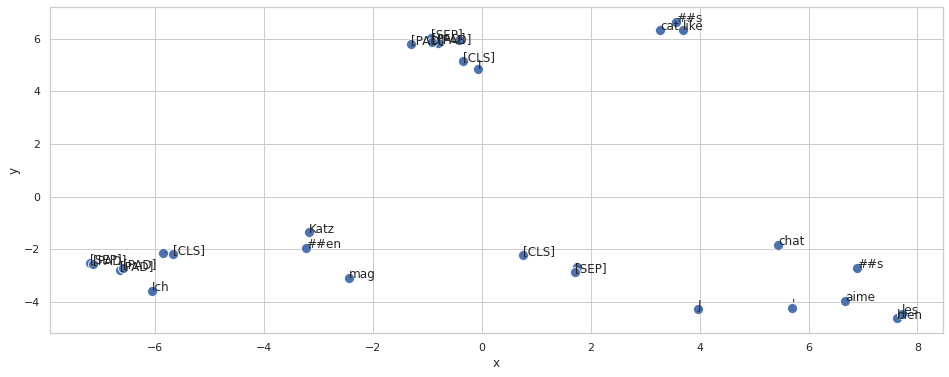

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(16, 6))

sns.set(style='whitegrid')
 
scatter = sns.scatterplot(data=output_2d, x='x', y='y', s=100)

for i in range(output_2d.shape[0]): scatter.annotate(tokens[i], (output_2d.x[i], output_2d.y[i]))

In [14]:
%load_ext tensorboard
%tensorboard --logdir /home/vagrant/project/logs/ --host 0.0.0.0 --port 6006

In [19]:
!ps -fA | grep tensorboard

vagrant   2570  2544  1 22:12 ?        00:00:04 /usr/bin/python3 /usr/local/bin/tensorboard --logdir /home/vagrant/project/logs/ --host 0.0.0.0 --port 6006
vagrant   2597  2544  0 22:15 pts/2    00:00:00 /bin/bash -c ps -fA | grep tensorboard
vagrant   2599  2597  0 22:15 pts/2    00:00:00 grep tensorboard


In [20]:
!kill 2570

### Sources
- https://stackoverflow.com/questions/61250311/error-importing-bert-module-tensorflow-api-v2-train-has-no-attribute-optimi#
- https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d
- https://huggingface.co/bert-base-multilingual-cased
- https://github.com/google-research/bert/blob/master/multilingual.md
- https://huggingface.co/transformers/main_classes/output.html
- https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd
- https://towardsdatascience.com/transformers-141e32e69591
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html#adding-a-projector-to-tensorboard

### References
- https://arxiv.org/abs/1810.04805
- https://www.aclweb.org/anthology/2020.tacl-1.54.pdf